pip install langgraph langchain-community tavily-python python-dotenv

In [5]:
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.

True

In [6]:
from typing import Annotated

# from langchain_anthropic import ChatAnthropic
from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatOllama(
    model="llama3.2:3b",
    temperature=0,
    # other params...
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

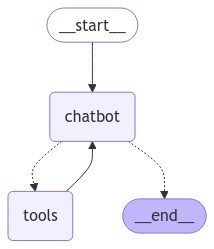

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
config = {"configurable": {"thread_id": "1"}}

user_input = "What's the best restaurant in Montreal?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the best restaurant in Montreal?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (974c3aaf-5cd2-4bcd-afc3-fa85ce2f81ad)
 Call ID: 974c3aaf-5cd2-4bcd-afc3-fa85ce2f81ad
  Args:
    query: best restaurants in Montreal
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://cultmtl.com/2024/10/the-top-25-restaurants-in-montreal-right-now/", "content": "1. Mon Lapin. Marc Olivier Frappier and Vanya Filipovic's Little Italy restaurant remains, month after month, the top restaurant in Montreal. Having nabbed the #1 spot on Canada's 100 Best Restaurants two years running, Mon Lapin's list of accolades only continues to grow. The food here is a poetic mixture of French and Italian cooking in"}, {"url": "https://www.theinfatuation.com/montreal/guides/montreal-